https://mne.tools/stable/auto_tutorials/clinical/60_sleep.html

In [12]:
#import matplotlib
%matplotlib qt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

import mne
from mne.datasets.sleep_physionet.age import fetch_data
#matplotlib.use('Qt5Agg')

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from C:\Users\nasta\mne_data\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


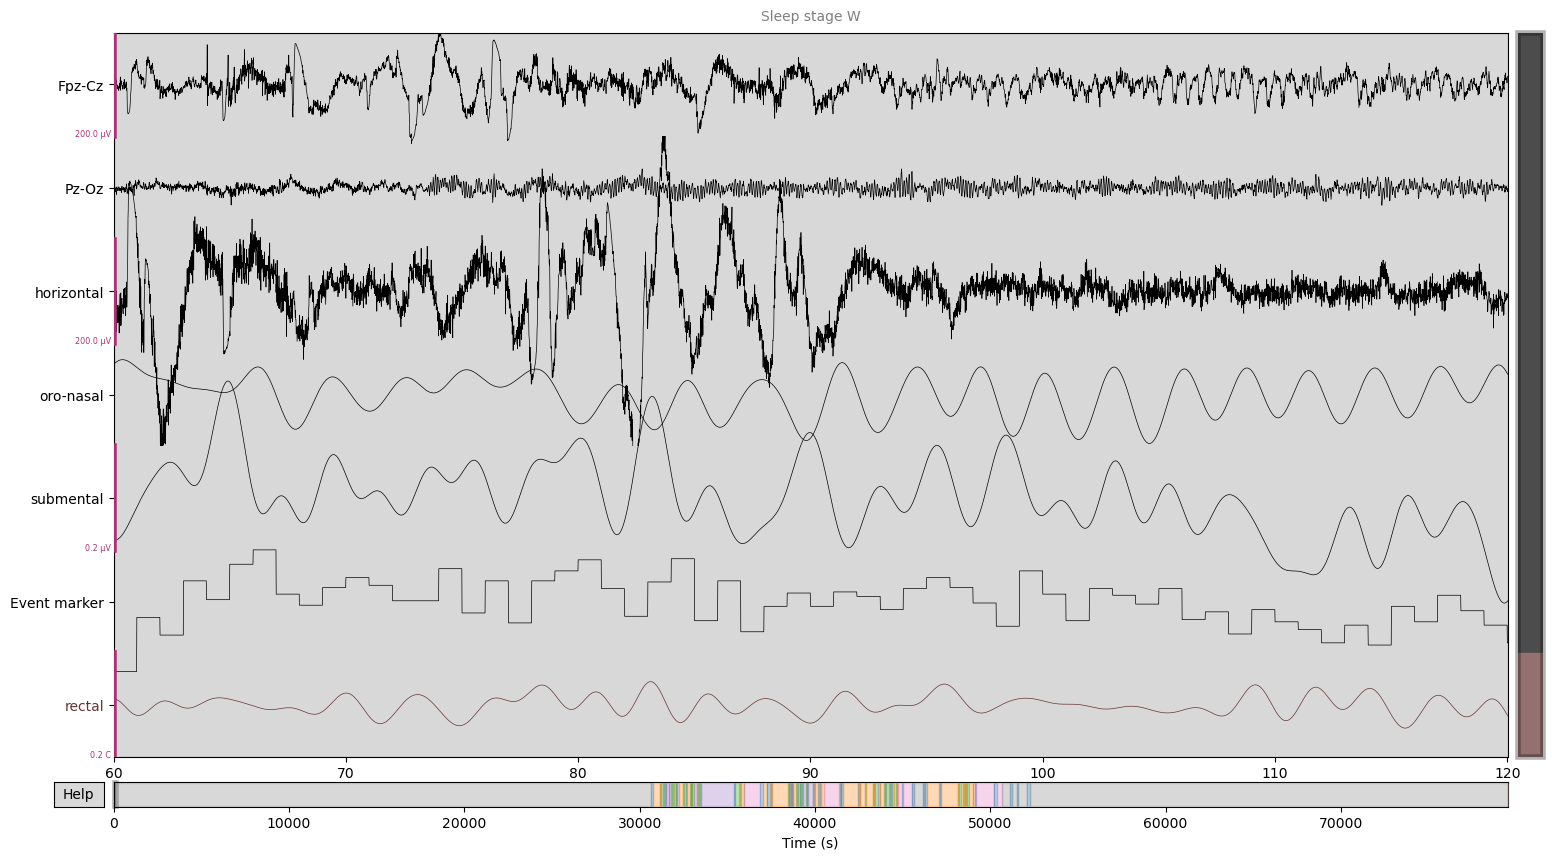

Channels marked as bad:
none


In [13]:
ALICE, BOB = 0, 1

[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])

raw_train = mne.io.read_raw_edf(
    alice_files[0], stim_channel="Event marker", infer_types=True, preload=True
)

annot_train = mne.read_annotations(alice_files[1])

raw_train.set_annotations(annot_train, emit_warning=False)

# plot some data
# scalings were chosen manually to allow for simultaneous visualization of
# different channel types in this specific dataset
raw_train.plot(
    start=60,
    duration=60,
    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1),
)

In [9]:
annotation_desc_2_event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 4,
    "Sleep stage R": 5,
}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]["onset"] - 30 * 60, annot_train[-2]["onset"] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)

# create a new event_id that unifies stages 3 and 4
event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3/4": 4,
    "Sleep stage R": 5,
}

# plot events
fig = mne.viz.plot_events(
    events_train,
    event_id=event_id,
    sfreq=raw_train.info["sfreq"],
    first_samp=events_train[0, 0],
)

# keep the color-code for further plotting
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


In [14]:
tmax = 30.0 - 1.0 / raw_train.info["sfreq"]  # tmax in included

epochs_train = mne.Epochs(
    raw=raw_train,
    events=events_train,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)
del raw_train

print(epochs_train)

Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  841 events (good & bad), 0 – 29.99 s, baseline off, ~13 kB, data not loaded,
 'Sleep stage W': 188
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125>


In [15]:
raw_test = mne.io.read_raw_edf(
    bob_files[0], stim_channel="Event marker", infer_types=True, preload=True
)
annot_test = mne.read_annotations(bob_files[1])
annot_test.crop(annot_test[1]["onset"] - 30 * 60, annot_test[-2]["onset"] + 30 * 60)
raw_test.set_annotations(annot_test, emit_warning=False)
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)
epochs_test = mne.Epochs(
    raw=raw_test,
    events=events_test,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)
del raw_test

print(epochs_test)

Extracting EDF parameters from C:\Users\nasta\mne_data\physionet-sleep-data\SC4011E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1103 events (good & bad), 0 – 29.99 s, baseline off, ~13 kB, data not loaded,
 'Sleep 